<a href="https://colab.research.google.com/github/sirfindcent/skimlit/blob/main/Notebooks/01_SkimLit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Milestone Project Milestone Project 2: SkimLit 📜🔥
The number of RCT papers released is continuing to increase, those without structured abstracts can be hard to read and in turn slow down researchers moving through the literature.

The purpose of this notebook is to make an NLP model to make reading medical abstracts easier.


![Skimlit example inputs and outputs](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/09-skimlit-overview-input-and-output.png)

> 📖 **Resources:** Before going through the code in this notebook, you might want to get a background of what we're going to be doing. To do so, spend an hour (or two) going through the following papers and then return to this notebook:
  1. Where our data is coming from: [*PubMed 200k RCT: a Dataset for Sequential Sentence Classification in Medical Abstracts*](https://arxiv.org/abs/1710.06071)
  2. Where the model that paper above is used came from: [*Neural networks for joint sentence classification in medical paper abstracts*](https://arxiv.org/pdf/1612.05251.pdf).

The main things we're going to do are:
1. Download the dataset [PubMed 200k RCT: a Dataset](https://arxiv.org/abs/1710.06071).
2. Format the data in a way that compatible with our goal and the deep learning models.
3. Turn the text labels into label encoded labels.
4. Prepare the data with TensorFlow to make sure our data can be effectively and effeciently learned by the models.
5. Do series of modelling experiments and start with the baseline.

## Confirm the GPU

In [ ]:
  !nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-85bfffac-c8e7-d560-6096-54c6b66713c2)


## Get data

Since we'll be replicating the paper above (PubMed 200k RCT), let's download the dataset they used.

We can do so for the authors GitHub:https://github.com/Franck-Dernoncourt/pubmed-rct

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
# !ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), done.


In [ ]:
!ls pubmed-rct

PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [ ]:
!ls pubmed-rct/PubMed_20k_RCT
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt
dev.txt  test.txt  train.txt


In [ ]:
# Start our experiments using the 20K dataset with number replaced by "@" sign
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [ ]:
# Check all of the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]

## Preprocess data
Now we've got some text data, it's time to become one with it.

And one of the best ways to become one with the data is to...

> Visualize, visualize, visualize

So with that in mind, let's write a function to read in all of the line of a target text file.

In [ ]:
# Create a function to read the lines of document
def get_lines(filename):
  """
  Reads filename (a text filename) and returns the lines of text as a list.

  Args:
    filename: a string containing the target filepath.

  Returns:
    A list of strings with one string per line from the target filename.
  """
  with open(filename, "r") as f:
    return f.readlines()

In [ ]:
# Let's read in the training lines
train_lines = get_lines(data_dir + "train.txt") # read the line with the training files
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [ ]:
len(train_lines)

210040

Let's think about how we want our data to look ...

How i think our data would be best represented...

```
[{'line_number': 0,
   'target': 'BACKROUND',
   'text': 'Emotional eating is associated with overeating and the development of obesity .\n'
   'total_lines': 11},
   ...]
```

Let's write a function which turns each of our datasets into the above format so we can continue to prepare our data for modelling.

What our function do is:

1.Everytime meet the start of abstract in our case Id ("###") :
  - Store id `acces_id = line`
  - Reset the `abstract_lines` every new abstract (since we add empty string of `abstract_lines` with each line in input_lines)

2.Add `abstract line`  with each lines in input line  when we not start ("###") or end ("\n") of each abstract.

3.Everytime meet the end of abstract in our case single space text ("\n") it will:
  - Using `.splitlines()` , we split each lines on  `abstract_lines`(string of line that we added before) by their "\n" at the end of each line and it turn the `abstract_lines` into list of line.
     ```
    abstract_lines = " "                                       #string
    line_1 = "This is line one\n"
    line_2 = "This is line two\n"
    
    abstract_lines =  abstract_lines + line_1  + line_2
    > 'This is line one\nThis is line two\n'

    # With splitlines
    abstract_lines.splitlines()
    > ['This is line one', 'This is line two']                  #list
    ```
    
  - Store splitted `abstract_lines` list to dictionary and back to process 1





In [ ]:
def preprocess_text_with_line_numbers(filename):
  """
  Returns a list of dictonaries of abstract line data.

  Takes in filename, reads some content and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number the target line is.
  """

  input_lines = get_lines(filename) # get all of the line
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  # Loop through each line on the target file
  for line in input_lines:
    # 1. Start
    if line.startswith("###"): # check to see if this an ID line
      abstract_id = line # put the id to variable
      abstract_lines = "" # reset the abstract string if the line is an ID line

    # 3.End (split input_lines into individual abstract and store on dict)
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into seperate lines and turn `abstract_lines` into list (see above instruction)

      # iterate through each line in a single abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split): # KEYNOTE: split into individual line on each abstract

        target_text_split = abstract_line.split('\t') # split target label from text

        # Create dictionary and put it into list
        line_data = {} # create an empty dictionary for each line
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are there in the target abstract? (start from zero)
        abstract_samples.append(line_data) # add line data to abstract samples list

    # 2.Add line to abstract_lines
    else: # if the above condition doesn't fulfilled, the line contains a labelled sentence
      abstract_lines += line

  return abstract_samples

In [ ]:
# Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt") # dev is another name for validation dataset
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
len(train_samples), len(val_samples), len(test_samples)

CPU times: user 388 ms, sys: 78.1 ms, total: 467 ms
Wall time: 467 ms


(180040, 30212, 30135)

In [ ]:
# Check the first abstract of our training data
train_samples[:14]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

Now that our data is in the format of a list of dictionary, how about we turn it into DataFrame to further visualize it.

In [ ]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [ ]:
# Distributions of labels in training data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

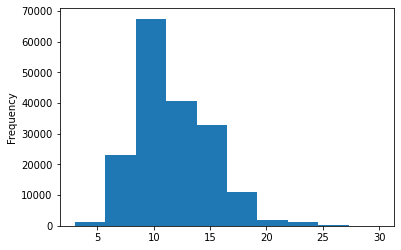

In [ ]:
# Let's check the length of different lines
train_df.total_lines.plot.hist() # number of sentences per abstract

### Get lists of sentences

In [ ]:
# Convert abstract text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [ ]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make numeric labels (ML models require numeric labels)

In [ ]:
# One hot encoded labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False) # we want non-sparse matrix bcz tensorflow is uncompatible with non_sparse matrix
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1)) # dont need `fit` bcz it has been learned the data structure on code above
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

# check what one hot encoded labels look like
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [ ]:
import tensorflow as tf
tf.constant(train_labels_one_hot)

<tf.Tensor: shape=(180040, 5), dtype=float64, numpy=
array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])>

### Label encoded labels

In [ ]:
# Extract labels ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [ ]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Starting a series of modelling experiments

As usual, we're going to be trying out a bunch of different models and seeing which one works best.

And as always we're going to start with a baseline (TF-IDF Multinomial Naieve Bayes classifier).

## Model 0: Getting a baseline

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([ # `Pipeline` simillar like `Sequential` (do step in order)
    ("tfidf", TfidfVectorizer() ), # (name, transformer)
    ("clf", MultinomialNB() )
])

# Fit the pipeline to the training data
model_0.fit(X=train_sentences,
            y=train_labels_encoded)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
# Evalualte baseline model on validation dataset
model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.7218323844829869

In [ ]:
# Make predictions using our baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [ ]:
val_labels_encoded

array([0, 0, 3, ..., 4, 1, 1])

### Download helper function script

In the previous module, we wrote a function to compare a predictions across different metrics (accuracy, precision, recall and f1) and rather than rewriting it here, let's download it from our helper function script: https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-12-26 11:54:26--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-12-26 11:54:26 (99.1 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import calculate_results

In [ ]:
# Calculate baseline results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

In [ ]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Preparing our data (the text) for deep sequence models

Before we start building deeper models, we've got to create vectorization and embedding layers.

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
# How long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

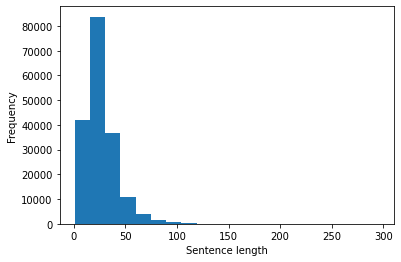

In [ ]:
# What's the distribution look like?
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=20)
plt.xlabel("Sentence length")
plt.ylabel("Frequency");

In [ ]:
# How long of a sentence length covers 95% of examples?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len # 95% length is under this output_seq_len

55

95% of our data is under output above that is **55**

In [ ]:
# Maximum sequence length in the training set
max(sent_lens)

296

### Create text vectorizer layer

We want to make a layer which maps our texts from words to numbers.
(Sequence -> Sequence vector)

In [ ]:
from tensorflow.keras import layers

In [ ]:
# How many words are in our vocab? (taken from table 2 in: https://arxiv.org/pdf/1710.06071.pdf)
max_tokens = 68000

In [ ]:
# Create text vectorizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens, #number of words in vocabulary
                                    output_sequence_length=output_seq_len) # desired output length of vectorized sequences

In [ ]:
# Adapt / fit  text vectorizer to training sentences
text_vectorizer.adapt(train_sentences) # text_vect learn the data structure of our train_sentences

In [ ]:
# Test out text vectorizer on random sentences
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text: {text_vectorizer([target_sentence])}")


Text:
baseline-corrected and uncorrected serum tt and ft pharmacokinetic parameters ( auc@-@ , c avg , cmax , and tmax ) were calculated using a standard model-independent approach .

Length of text: 28

Vectorized text: [[27362     3  4559   225  2017     3  3983  1315   315   802   243  9772
   2071     3  5607     9   757    59     8   165 36827   453     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [ ]:
# How many words in our training vocabulary?
rct_20k_text_vocab = text_vectorizer.get_vocabulary()

# Explore the vocab
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Most common words in vocab: {rct_20k_text_vocab[:5]}")
print(f"Least common words in vocab: {rct_20k_text_vocab[-5:]}")

Number of words in vocab: 64841
Most common words in vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [ ]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None}

### Create custom embedding

In [ ]:
# Create token embedding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab), # length of vocabulary
                             output_dim=128, # Note: different embedding sizes result in drastically different number of parameters to train,
                             mask_zero=True, # use masking to handle variable sequence length / do more efficent computing when there're a lot zero in your input data
                             name="token_embedding")


In [ ]:
# Show example embedding
print(f"Sentence before vectorization:\n {target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization:\n {vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n {embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
 baseline-corrected and uncorrected serum tt and ft pharmacokinetic parameters ( auc@-@ , c avg , cmax , and tmax ) were calculated using a standard model-independent approach .

Sentence after vectorization:
 [[27362     3  4559   225  2017     3  3983  1315   315   802   243  9772
   2071     3  5607     9   757    59     8   165 36827   453     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after embedding:
 [[[ 0.01493584 -0.04412311  0.01512117 ... -0.0188368   0.03620286
    0.04760248]
  [ 0.03845767  0.04972941  0.02720625 ... -0.04479942  0.01783833
    0.01097513]
  [-0.04176477 -0.00955291  0.02860553 ...  0.01496663  0.02999164
   -0.01211834]
  ...
  [ 0.03617785 -0.00051054 -0.02467059 ...  0.04757688  0.03775713
    0.02866845]
  [ 0.03617785 -0.00051054 -0.02467059 ...  0.04757

## Creating datasets (making sure our data load as fast as possible)

We're going to setup our data to run as fast as possible with the TensorFlow tf.data.API, many of the steps here are discussed at lenght in these two resources:
* https://www.tensorflow.org/guide/data_performance
* https://www.tensorflow.org/guide/data

In [ ]:
# Turn our data into TensorFlow Datasets (make sure tensorflow load our data as fast as possible)
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))
train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [ ]:
# Take the TensorSliceDataset's and turn them into prefected datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1: Conv1D with token embeddings

In [ ]:
# Create 1d conv model to process sequences
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs) # vectorize text inputs
token_embeddings = token_embed(text_vectors) # create embedding
x = layers.Conv1D(filters=64, kernel_size=5)(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) # condese the output of our feature vector from conv layer
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

# Compile
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 51, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

In [ ]:
history_1 = model_1.fit(train_dataset,
                        steps_per_epoch=int(0.1 * len(train_dataset)), # train on 10% of our batch
                        epochs=3,
                        validation_data=valid_dataset,
                        validation_steps=int(0.1 * len(valid_dataset)) # only validate on 10% of batches
                        )

Epoch 1/3
562/562 [==============================] - 13s 9ms/step - loss: 0.9251 - accuracy: 0.6296 - val_loss: 0.6983 - val_accuracy: 0.7267
Epoch 2/3
562/562 [==============================] - 5s 8ms/step - loss: 0.6726 - accuracy: 0.7498 - val_loss: 0.6432 - val_accuracy: 0.7640
Epoch 3/3
562/562 [==============================] - 5s 8ms/step - loss: 0.6281 - accuracy: 0.7687 - val_loss: 0.5992 - val_accuracy: 0.7749


In [ ]:
# Evaluate on whole validation dataset
model_1.evaluate(valid_dataset  )

945/945 [==============================] - 3s 3ms/step - loss: 0.6006 - accuracy: 0.7801


[0.6005521416664124, 0.7801204919815063]

In [ ]:
# Make predictions (our model predicts prediction probabilities for each class)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs

945/945 [==============================] - 2s 2ms/step


array([[4.76807296e-01, 1.21778645e-01, 1.00660928e-01, 2.73939341e-01,
        2.68138573e-02],
       [4.31156784e-01, 1.89101428e-01, 1.47267962e-02, 3.55534256e-01,
        9.48076509e-03],
       [1.69071138e-01, 7.28828600e-03, 1.99487666e-03, 8.21630895e-01,
        1.48645850e-05],
       ...,
       [1.01126825e-05, 7.94300751e-04, 2.75130407e-03, 8.32614842e-06,
        9.96436000e-01],
       [6.11721799e-02, 4.47513521e-01, 1.62516192e-01, 8.97184685e-02,
        2.39079654e-01],
       [1.48848101e-01, 6.73570693e-01, 1.01408407e-01, 3.45231630e-02,
        4.16497104e-02]], dtype=float32)

In [ ]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [ ]:
# Calculate model_1 results
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.01204819277109,
 'precision': 0.7773278144569901,
 'recall': 0.7801204819277109,
 'f1': 0.7770518721170461}

In [ ]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Model 2: Feature extraction with pretrained token embeddings

Now let's use pretrained word embedding from TensorFlow Hub more specifically the universal sentence encoder:https://tfhub.dev/google/universal-sentence-encoder/4

The paper originally used GloVe embeddings, however we're going to stick with later created USE pretrained embeddings.

In [ ]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [ ]:
# Test out the pretrained embeddings on random sentence
random_training_sentence = random.choice(train_sentences)
print(f"Random sentence:\n {random_training_sentence}")
use_embedded_sentence = tf_hub_embedding_layer([random_training_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]}\n")
print(f"Length  of sentence embedding: {len(use_embedded_sentence[0])}")

Random sentence:
 luteal phase administration of cc in patients with pcos leads to increased follicular growth and endometrial thickness , which might result in a higher pregnancy rate .
Sentence after embedding:
[-0.03313118 -0.02431869  0.06065408 -0.0201045  -0.04074775 -0.05588533
  0.02388962 -0.06287922  0.0588631   0.04885599  0.07523455 -0.07860274
 -0.00710358  0.04056631  0.06359373  0.0540425  -0.08068274  0.00903851
  0.03255909  0.06559313 -0.02111638  0.06940957  0.00598163 -0.06273115
  0.07672924 -0.04198803 -0.0562286  -0.02705209 -0.07504936  0.05062748]

Length  of sentence embedding: 512


## Building and fitting an NLP feature extraction model from TensorFlow Hub

In [ ]:
# Define feature extraction model using TF Hub layer (functional API)
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs) # tokenize text and create embedding for each sequence (512 long vector)
x = layers.Dense(128, activation="relu")(pretrained_embedding)
#Note: you could more layers here if you wanted to
outputs = layers.Dense(num_classes, activation="softmax")(x) # create the output layer
model_2 = tf.keras.Model(inputs, outputs,
                         name="model_2_USE_feature_extractor")

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics="accuracy")

In [ ]:
# Train a classifiers on top of USE model
model_2.fit(train_dataset,
            steps_per_epoch=int(0.1 * len(train_dataset)), # train on 10% of batches
            epochs=3,
            validation_data=valid_dataset,
            validation_steps=int(0.1 * len(valid_dataset))) # valildating on 10% of valid dataset

Epoch 1/3
562/562 [==============================] - 9s 13ms/step - loss: 0.9157 - accuracy: 0.6520 - val_loss: 0.7971 - val_accuracy: 0.6875
Epoch 2/3
562/562 [==============================] - 7s 12ms/step - loss: 0.7685 - accuracy: 0.7015 - val_loss: 0.7555 - val_accuracy: 0.7055
Epoch 3/3
562/562 [==============================] - 7s 12ms/step - loss: 0.7513 - accuracy: 0.7139 - val_loss: 0.7390 - val_accuracy: 0.7121


In [ ]:
# Evaluate on the whole validation dataset
model_2.evaluate(valid_dataset)

945/945 [==============================] - 10s 10ms/step - loss: 0.7408 - accuracy: 0.7139


[0.7407770752906799, 0.7138554453849792]

In [ ]:
# Make predictions with feature extraction model
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

945/945 [==============================] - 9s 10ms/step


array([[0.40892184, 0.38289624, 0.0024128 , 0.19805884, 0.00771031],
       [0.3735609 , 0.4811027 , 0.00405214, 0.13866456, 0.00261975],
       [0.20668614, 0.1648294 , 0.0195517 , 0.57163465, 0.03729807],
       ...,
       [0.00194522, 0.00506215, 0.05819263, 0.00093917, 0.9338609 ],
       [0.0039878 , 0.05168469, 0.1998487 , 0.00189022, 0.7425886 ],
       [0.19854885, 0.25748834, 0.481202  , 0.00684324, 0.05591751]],
      dtype=float32)

In [ ]:
# Convert prediction probabilities found with feature extraction model to label
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)

In [ ]:
# Calculate results from TF Hub pretrained embeddings results on val set
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 71.3855421686747,
 'precision': 0.7138602268652583,
 'recall': 0.713855421686747,
 'f1': 0.7107417994465617}

## Model 3: Conv1D with character embeddings

The paper which we're replicating, states that they used a combination of token and character-level embeddings.

Previously we've made token-level embeddings but we'll need to do simillar steps for characeters if we want to use char-level embeddings.

### Create character-level tokenizer  

In [ ]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [ ]:
# Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

# Text splitting non-character sequence into characters
split_chars(random_training_sentence)

NameError: ignored

In [ ]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [ ]:
train_sentences[0]

'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .'

In [ ]:
# What's the average character length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
char_lens[0]

281

(array([1.41175e+05, 3.71110e+04, 1.60000e+03, 1.27000e+02, 2.10000e+01,
        5.00000e+00, 1.00000e+00]),
 array([1.00000000e+00, 1.98857143e+02, 3.96714286e+02, 5.94571429e+02,
        7.92428571e+02, 9.90285714e+02, 1.18814286e+03, 1.38600000e+03]),
 <a list of 7 Patch objects>)

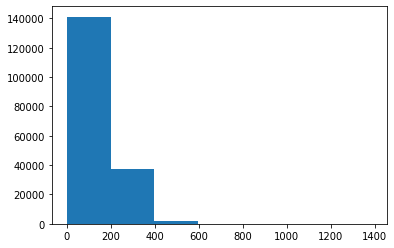

In [ ]:
# Check the distribution of our sequence at character-level
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=7)

In [ ]:
# Find what character length cover 95% sequence
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len # this char length cover 95% sequence

290

In [ ]:
# Get all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # add 2 for space and OOV token (OOV = out of vocab, "[UNK]")
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    # standardize=None, # set standarization to "None" if you want to leave punctuation in
                                    name="char_vectorizer")

In [ ]:
# Adapt character vectorizer to training character
char_vectorizer.adapt(train_chars)

In [ ]:
# Check character vocab stats (without standardization)
char_vocab = char_vectorizer.get_vocabulary()

# Explore the vocab
print(f"Number of different characters on character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5]}")

Number of different characters on character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: k


In [ ]:
# Check character vocab stats (with standardization "lower_and_strip_punctuation")
char_vocab = char_vectorizer.get_vocabulary()

# Explore the vocab
print(f"Number of different characters on character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5]}")

Number of different characters on character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: k


In [ ]:
# Turn out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n {random_train_chars}")
print(f"\nLength of random_train_chars: {len(random_train_chars.split())}") # use .split() so the `len()` doesn't count the whitespace
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars: {vectorized_chars}")
print(f"\n Length of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
 m o r e   p a t i e n t s   i n   t h e   @ : @ : @   g r o u p   a c h i e v e d   h e m o s t a s i s   t h a n   i n   t h e   @ : @ : @   g r o u p   (   @   %   v s   @   %   ,   r e s p e c t i v e l y   ;   p   =   @   )   .

Length of random_train_chars: 90

Vectorized chars: [[15  7  8  2 14  5  3  4  2  6  3  9  4  6  3 13  2 18  8  7 16 14  5 11
  13  4  2 21  2 10 13  2 15  7  9  3  5  9  4  9  3 13  5  6  4  6  3 13
   2 18  8  7 16 14 21  9  8  2  9 14  2 11  3  4 21  2 12 19 14  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0 

### Creating a char-level embedding

In [ ]:
# Create char embedding layer
char_embed = layers.Embedding(input_dim=len(char_vocab), # number of different characters
                                            output_dim=25, # this is the size of the char embedding in this paper: https://arxiv.org/abs/1710.06071
                                            mask_zero=True,
                                            name="token_embedding")

In [ ]:
# Test our character embedding layer
print(f"Charified text:\n {random_train_chars}")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars. (after vectorization and embedding):\n {char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text:
 m o r e   p a t i e n t s   i n   t h e   @ : @ : @   g r o u p   a c h i e v e d   h e m o s t a s i s   t h a n   i n   t h e   @ : @ : @   g r o u p   (   @   %   v s   @   %   ,   r e s p e c t i v e l y   ;   p   =   @   )   .
Embedded chars. (after vectorization and embedding):
 [[[-0.01671903 -0.02034162  0.0069354  ... -0.02482986  0.03744345
   -0.0375813 ]
  [-0.00680257 -0.0151543  -0.01714943 ...  0.03659535  0.04974015
    0.03765051]
  [-0.04211384 -0.00882524 -0.02943598 ...  0.04209482  0.02809911
   -0.02565957]
  ...
  [ 0.03570112  0.01583085 -0.02682352 ... -0.02056544 -0.01076114
    0.00594387]
  [ 0.03570112  0.01583085 -0.02682352 ... -0.02056544 -0.01076114
    0.00594387]
  [ 0.03570112  0.01583085 -0.02682352 ... -0.02056544 -0.01076114
    0.00594387]]]

Character embedding shape: (1, 290, 25)


### Model 3: Conv1D with character embedding

### Building a Conv1D model to fit on character embedding

In [ ]:
# Make Conv1D on chars only
inputs = layers.Input(shape=(1,), dtype=tf.string)
char_vector = char_vectorizer(inputs)
char_embeddings = char_embed(char_vector)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_3_conv1d_char_embeddings")

# Compile
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


In [ ]:
model_3.summary()

Model: "model_3_conv1d_char_embeddings"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 token_embedding (Embedding)  (None, 290, 25)          700       
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_3 (Dense)             (None, 

In [ ]:
# Create char-level dataset
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
# Fit the model on chars only
model_3_history = model_3.fit(train_char_dataset,
                        steps_per_epoch=int(0.1 * len(train_char_dataset)),
                        epochs=3,
                        validation_data=val_char_dataset,
                        validation_steps=int(0.1 * len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 4s 6ms/step - loss: 1.2653 - accuracy: 0.4830 - val_loss: 1.0544 - val_accuracy: 0.5765
Epoch 2/3
562/562 [==============================] - 3s 5ms/step - loss: 1.0213 - accuracy: 0.5846 - val_loss: 0.9557 - val_accuracy: 0.6187
Epoch 3/3
562/562 [==============================] - 3s 5ms/step - loss: 0.9420 - accuracy: 0.6268 - val_loss: 0.8859 - val_accuracy: 0.6506


In [ ]:
# Evaluate on whole validation data
model_3.evaluate(val_char_dataset)

945/945 [==============================] - 3s 4ms/step - loss: 0.8984 - accuracy: 0.6486


[0.8984229564666748, 0.6485833525657654]

In [ ]:
# Make predictions with character model only
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

945/945 [==============================] - 2s 2ms/step


array([[0.12554173, 0.29695424, 0.20471251, 0.31234798, 0.06044349],
       [0.20184755, 0.5472795 , 0.02865954, 0.12260061, 0.09961285],
       [0.11687658, 0.40249184, 0.17786574, 0.21372554, 0.08904026],
       ...,
       [0.01728628, 0.0302645 , 0.24959093, 0.02433445, 0.67852384],
       [0.01659893, 0.09458647, 0.40534765, 0.05916558, 0.4243014 ],
       [0.47514114, 0.33493182, 0.07137469, 0.11096586, 0.00758637]],
      dtype=float32)

In [ ]:
# Convert prediction probabilities to class labels
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([3, 1, 1, ..., 4, 4, 0])>

In [ ]:
# Calculate results for Conv1D model chars only
model_3_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 64.8583344366477,
 'precision': 0.6390389767645799,
 'recall': 0.6485833443664769,
 'f1': 0.6392387358654369}

## Model 4: Combining pretrained token embeddings + characters embeddings ()

1. Create token-level embedding model (simmilar `model_1`)
2. Create character-level model (similar to `model_3` with a slight modification)
3. Combine 1 & 2 with a concatenate (`layers.Concatenate`)
4. Build a series of output layers on top of 3 similar to Figure 1 and section 4.2 of https://arxiv.org/pdf/1612.05251.pdf
5. Construct a model which takes token and character-level sequences as input and produces sequence label probabilities as output

In [ ]:
# Define feature extraction model using TF Hub layer (functional API)
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs) # tokenize text and create embedding for each sequence (512 long vector)
x = layers.Dense(128, activation="relu")(pretrained_embedding)
#Note: you could more layers here if you wanted to
outputs = layers.Dense(num_classes, activation="softmax")(x) # create the output layer
model_2 = tf.keras.Model(inputs, outputs,
                         name="model_2_USE_feature_extractor")


In [ ]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)
# 2. Setup char inputs/model
char_inputs =  layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings) # bi-LSTM show in figure 1 of https://arxiv.org/pdf/1612.05251.pdf
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Concatenate token and char inputs (create hybird token embeddings)
token_char_concat = layers.Concatenate(name="token_char_hybird")([token_model.output,
                                          char_model.output])

# 4. Create outputs layer - adding in Dropout, disucced in section 4.2 of https://arxiv.org/pdf/1612.05251.pdf
combined_dropout = layers.Dropout(0.5)(token_char_concat) # randomly set 50% of input units/neurons to 0 at each step - dropout applied to character ehanced token embeddings
combined_dense = layers.Dense(128, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense) # dropout before the label prediction layer
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_inputs, char_inputs],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")

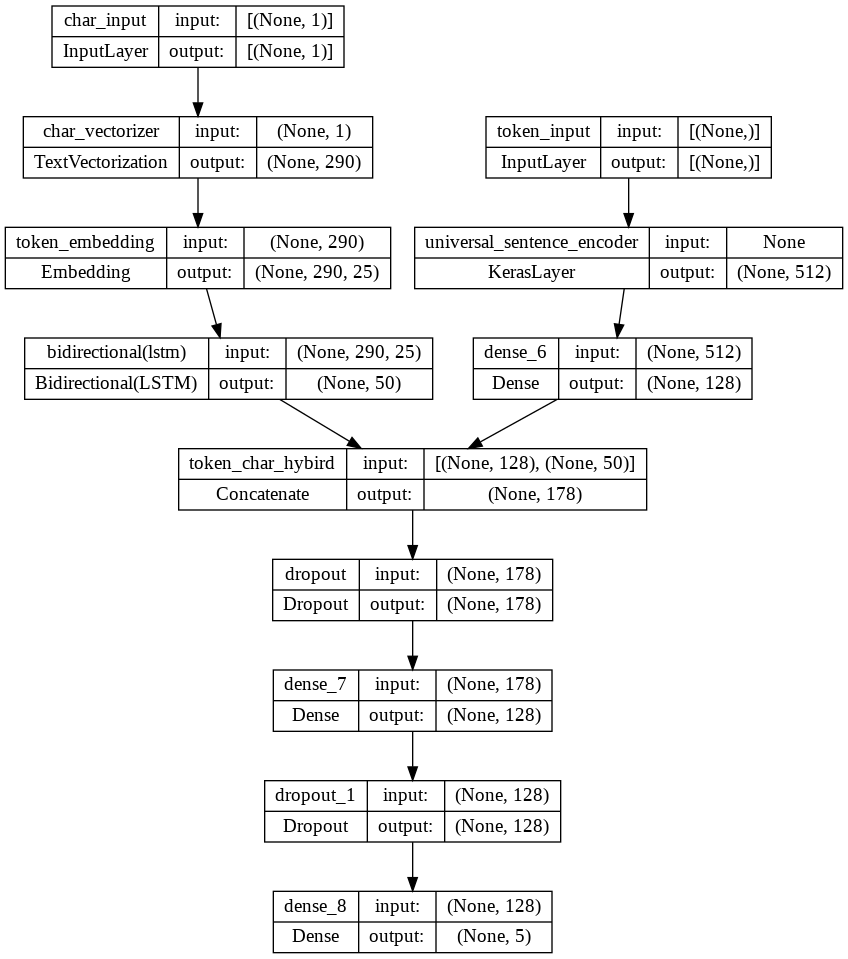

In [ ]:
# Plot hybrid token and character model
from keras.utils.vis_utils import plot_model
plot_model(model_4, show_shapes=True)

In [ ]:
# Compile token char model
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(), # section 4.2 of the paper says they use SGD, you might want to try
                metrics=["accuracy"])

### Combining token and character data with tf.data.Dataset

In [ ]:
# Combine chars and tokens into dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices((train_labels_one_hot)) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Repeat the above steps for our validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars)) # make data
val_char_token_labels = tf.data.Dataset.from_tensor_slices((val_labels_one_hot)) # make labels
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels)) # combine data and labels
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Check out our training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fitting a model on token and character-level sequences

In [ ]:
# Fit the model on tokens and chars
model_4_history = model_4.fit(train_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 38s 52ms/step - loss: 0.9867 - accuracy: 0.6138 - val_loss: 0.7805 - val_accuracy: 0.7035
Epoch 2/3
562/562 [==============================] - 27s 47ms/step - loss: 0.8043 - accuracy: 0.6896 - val_loss: 0.7248 - val_accuracy: 0.7277
Epoch 3/3
562/562 [==============================] - 24s 43ms/step - loss: 0.7760 - accuracy: 0.7025 - val_loss: 0.6926 - val_accuracy: 0.7400


In [ ]:
# Evaluate on whole dataset
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 21s 22ms/step - loss: 0.6968 - accuracy: 0.7357


[0.6967639327049255, 0.7357341647148132]

In [ ]:
# Make predictions using the token-character model hybrid
model_4_pred_probs = model_4.predict(val_char_token_dataset)

945/945 [==============================] - 23s 22ms/step


In [ ]:
# Format pred probs into pred label
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 0])>

In [ ]:
# Get results of token-char-hybrid-model
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 73.57341453726995,
 'precision': 0.7357161747787114,
 'recall': 0.7357341453726995,
 'f1': 0.7329315105145516}

## Model 5: Transfer learning with pretrained token embeddings and character embeddings + positional embeddings

> 🔑 **Note:** Any enggineered features used to train a model need to be available at test time, in our case line numbers and total lines are available

### Create positional embeddings

In [ ]:
# How many different line numbers are there?
train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

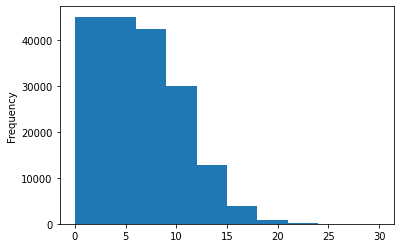

In [ ]:
# Check the distribution of "line_number" column
train_df.line_number.plot.hist()

In [ ]:
# Use TensorFlow to create one-hot encoded tensors of our "line_number" column
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15) # 15 bcz it covered 95% percent of line-number
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)
train_line_numbers_one_hot[:10], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>, TensorShape([180040, 15]))

Now we've encoded our line number feature, let's do the same for our total line feature...

In [ ]:
# How many different total lines are there
train_df["total_lines"].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

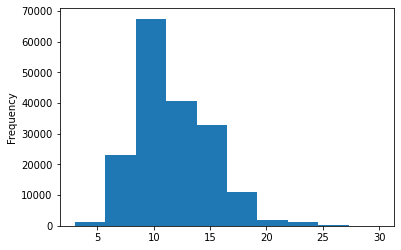

In [ ]:
# Check the distribution of total lines
train_df.total_lines.plot.hist() # the smaller bins (bigger param value) the more specific histogram plot

In [ ]:
# Check the covarage of a `total_lines` value of 20
np.percentile(train_df.total_lines, 98)

20.0

In [ ]:
# Use tensorflow to create one-hot-encoded tensor of our "total_lines" feature
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

train_total_lines_one_hot[:10], train_total_lines_one_hot.shape

(<tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0

### Building a tribrid embedding model

1. Create token-level model
2. Create character-level model
3. Create a model for the "line_number" feature
4. Create a model for the "total_lines" feature
5. Combine the outputs of 1 & 2 using tf.keras.layers.Concatenate
6. Combine the outputs of 3, 4, 5 using tf.keras.layers.Concatenate
7. Create output layer to accept that tribrid embedding and output label probabilities
8. Combine the inputs 1, 2, 3, 4 and outputs of into tf.keras.Model

In [ ]:
# 1. Token inputs (pretrained embedding)
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_inputs") # variable length shape
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Char inputs (own custom embedding)
char_inputs = layers.Input(shape=(1,), dtype=tf.string,  name="char_inputs") # 1 sequence shape
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24), name="bi_lstm_layer")(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Line numbers model (positional embeddings)
line_number_inputs = layers.Input(shape=(15,), dtype=tf.float32,  name="line_number_input") # train_line_number_one_hot[0].shape
x = layers.Dense(32, activation="relu")(line_number_inputs) # passing to layers.embedding is equivalent to pass it to layers.Dense
# combine inputs & dense layer into model
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                    outputs=x)

# 4. Total lines model
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.float32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=y)

# 5. Combine token and char embeddings into hybrid embedding
combined_embeddings = layers.Concatenate(name="char_token_hybrid_embedding")([token_model.output,
                                                                              char_model.output])
z = layers.Dense(128, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embedding with combined token and char embeddings into a tribrid embeddings
tribrid_embeddings = layers.Concatenate(name="char_token_positional_embedding")([line_number_model.output,
                                                                                 total_line_model.output,
                                                                                 z])
# 7. Create output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(tribrid_embeddings)

# 8. Put together all model with all kinds of inputs
model_5 = tf.keras.Model([line_number_model.input, # the order of inputs is important
                          total_line_model.input,
                          token_model.input,
                          char_model.input],
                          outputs=output_layer,
                         name="model_5_tribrid_embedding_model")

In [ ]:
# Get a summary of our tribrid embedding model
model_5.summary()

Model: "model_5_tribrid_embedding_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['t

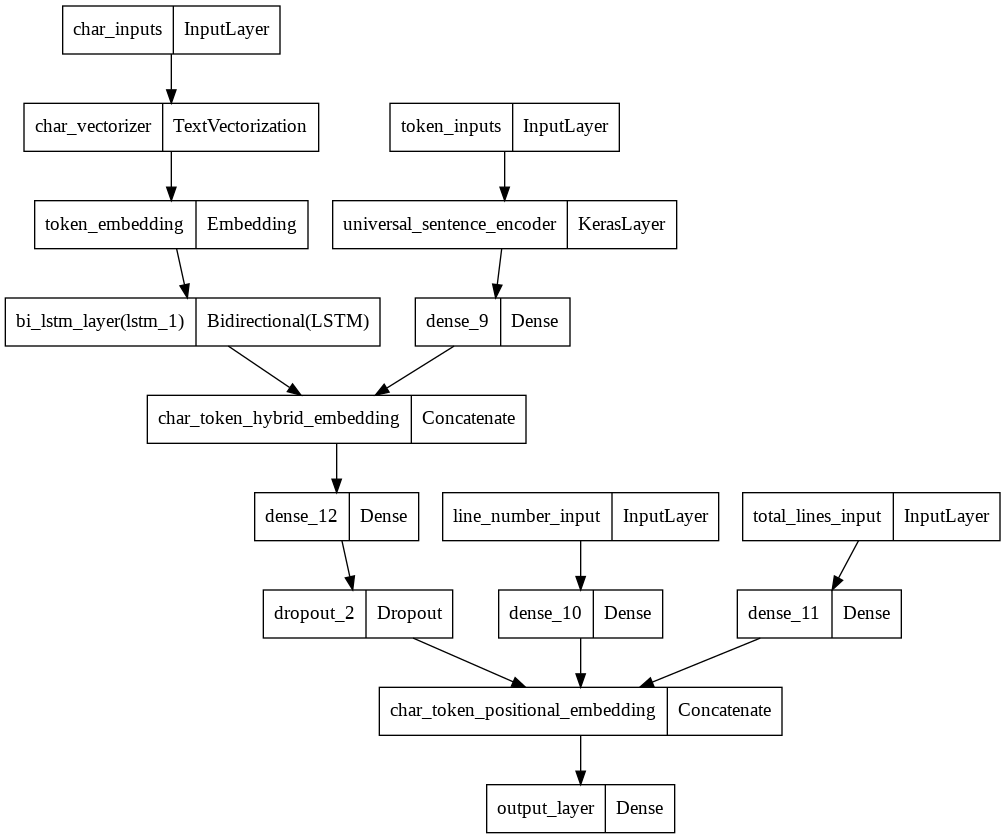

In [ ]:
# Plot model_5 to explore it visually
plot_model(model_5)

What is label smoothing?

For example if our model gets too confident on single class (e.g. it's prediction probability is really high), it may get stuck on that class and not consider other classes...

Really confident: `[0.0, 0.0, 1.0, 0.0, 0.0]`

What label smoothing does is it assigns some of the value from the highest pred prob to other classes in turn, hopefully improve generalization: `[0.01, 0.01, 0.96, 0.01, 0.01]`

> 📖 **Resource:** for more on label smoothing, see this blog post from PyImageSearch:https://pyimagesearch.com/2019/12/30/label-smoothing-with-keras-tensorflow-and-deep-learning/

In [ ]:
# Compile token,char and positional embedding model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # help to prevent overfitting
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

### Create tribid embedding datasets using tf.data

In [ ]:
# Create training and validation datasets (with all four kinds of input data)
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, # the order same as how we construct model_5 above
                                                                train_total_lines_one_hot,
                                                                train_sentences,
                                                                train_chars))
train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices((train_labels_one_hot))
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pos_labels))
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Do the same as above but for validation dataset
val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot, # the order same as how we construct model_5 above
                                                                val_total_lines_one_hot,
                                                                val_sentences,
                                                                val_chars))
val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices((val_labels_one_hot))
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_pos_labels))
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Check input shapes
train_char_token_pos_dataset, val_char_token_pos_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fitting, evaluating and making predictions with our tribrid model

In [ ]:
# Fit our tribrid embedding model
model_5_history = model_5.fit(train_char_token_pos_dataset,
            steps_per_epoch=int(0.1 * len(train_char_token_pos_dataset)),
            epochs=3,
            validation_data=val_char_token_pos_dataset,
            validation_steps=int(0.1 * len(val_char_token_pos_dataset)).
            callbacks=[tf.keras.callbacks.ModelCheckpoint()])

Epoch 1/3
562/562 [==============================] - 38s 53ms/step - loss: 1.1051 - accuracy: 0.7211 - val_loss: 0.9882 - val_accuracy: 0.7949
Epoch 2/3
562/562 [==============================] - 27s 48ms/step - loss: 0.9779 - accuracy: 0.8068 - val_loss: 0.9558 - val_accuracy: 0.8218
Epoch 3/3
562/562 [==============================] - 24s 43ms/step - loss: 0.9581 - accuracy: 0.8190 - val_loss: 0.9429 - val_accuracy: 0.8321


In [ ]:
# Make predictions with char token pos model
model_5_pred_probs = model_5.predict(val_char_token_pos_dataset)
model_5_pred_probs[:5]

945/945 [==============================] - 23s 22ms/step


array([[0.47434193, 0.13609183, 0.01248219, 0.35392472, 0.02315935],
       [0.52264947, 0.11830386, 0.04411889, 0.30303103, 0.01189678],
       [0.2611305 , 0.11120605, 0.11223555, 0.4469756 , 0.06845228],
       [0.04493885, 0.0659407 , 0.7080139 , 0.04214001, 0.13896659],
       [0.05481216, 0.08071534, 0.6524439 , 0.05273511, 0.15929349]],
      dtype=float32)

In [ ]:
# Convert pred probs into to label
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds[:5]

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([0, 0, 3, 2, 2])>

In [ ]:
# Calculate results of char token pos model
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 82.95379319475705,
 'precision': 0.8279147217799,
 'recall': 0.8295379319475705,
 'f1': 0.8283940823193163}

## Compare model results

In [ ]:
# Combine model results into dataframe
all_model_results = pd.DataFrame({"model_0_baseline": baseline_results,
                                  "model_1_custom_token_embedding": model_1_results,
                                  "model_2_pretrained_token_embedding": model_2_results,
                                  "model_3 custom_char_embedding": model_3_results,
                                  "model_4_hybrid_char_token_embedding": model_4_results,
                                  "model_5_pos_char_token_embedding": model_5_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
model_0_baseline,72.183238,0.718647,0.721832,0.698925
model_1_custom_token_embedding,78.012048,0.777328,0.780120,0.777052
model_2_pretrained_token_embedding,71.385542,0.713860,0.713855,0.710742
model_3 custom_char_embedding,64.858334,0.639039,0.648583,0.639239
model_4_hybrid_char_token_embedding,73.573415,0.735716,0.735734,0.732932
model_5_pos_char_token_embedding,82.953793,0.827915,0.829538,0.828394


In [ ]:
# Reduce the accuracy to the same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

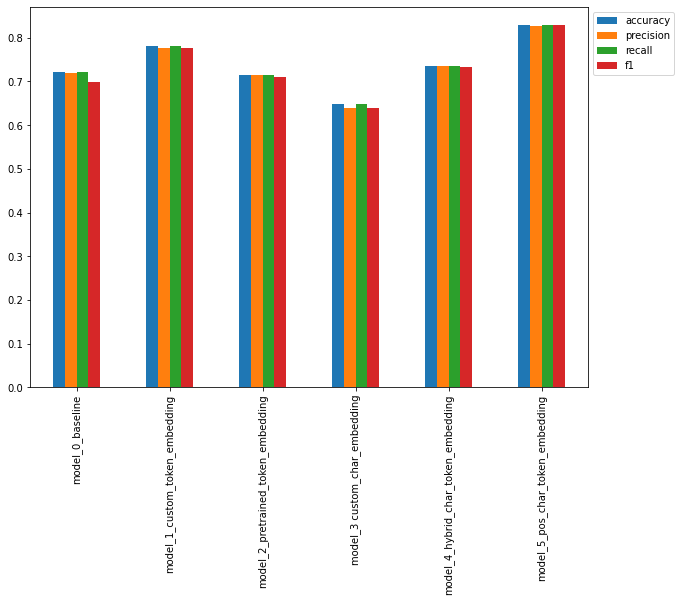

In [ ]:
# Plot and compare all the model results
all_model_results.plot(kind="bar",figsize=(10,7)).legend(bbox_to_anchor=(1.0, 1.0))

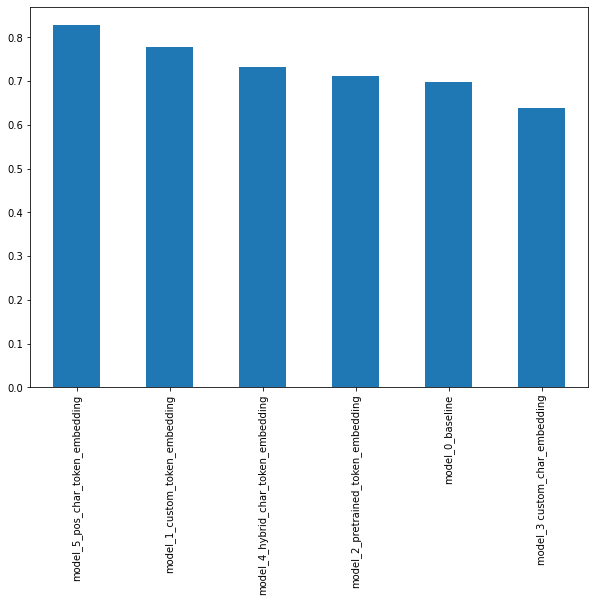

In [ ]:

# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));

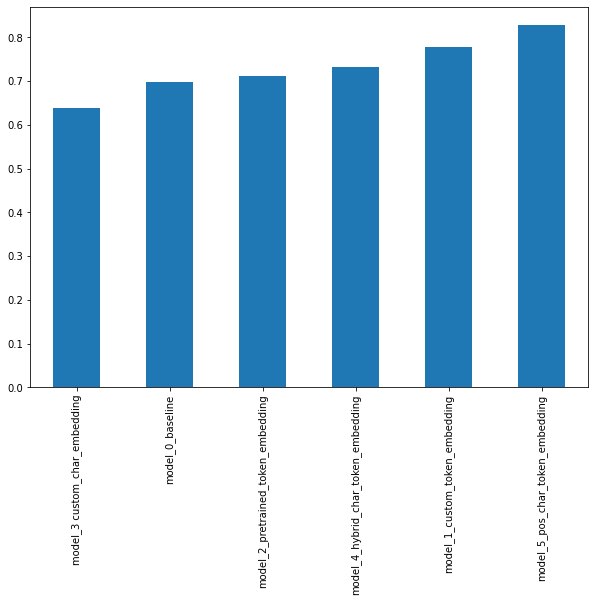

In [ ]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=True)["f1"].plot(kind="bar", figsize=(10,7));

## Save and Load Model

In [ ]:
# Save the best performing model to SavedModel format
model_5.save("/content/drive/MyDrive/ml-and-ds/Project/Classification/Skimlit/skimlit_tribrid_model")

In [ ]:
model_5.save("skimlit_tribrid_model")

In [ ]:
# Load in best performing model
loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/ml-and-ds/Project/Classification/Skimlit/skimlit_tribrid_model_1" )

In [ ]:
# Make predictions with the loaded model on validation datasest
loaded_pred_probs = loaded_model.predict(val_char_token_pos_dataset)
loaded_preds = tf.argmax(loaded_pred_probs, axis=1)
loaded_preds[:5]

945/945 [==============================] - 24s 22ms/step


<tf.Tensor: shape=(5,), dtype=int64, numpy=array([0, 0, 3, 2, 2])>

In [ ]:
# Calculate results of our loaded model
loaded_model_results = calculate_results(y_true=val_labels_encoded,
                                         y_pred=loaded_preds)
loaded_model_results

{'accuracy': 82.95379319475705,
 'precision': 0.8279147217799,
 'recall': 0.8295379319475705,
 'f1': 0.8283940823193163}

In [ ]:
assert model_5_results == loaded_model_results

In [ ]:
# Check the loaded model summary
loaded_model.summary()

## Your challenges

1. Turn the test data samples into tf.data.Dataset (fast loading) and then evaluate (make predictions) the best performing model on the test samples.
2. Find the most wrong predictions from 1 (these are the samples where the model has predicted the wrong label with the highest prediction probability)
3. Make example predictions (on RCT abstracts from the wild), you can go to PubMed to find these: https://pubmed.ncbi.nlm.nih.gov/, find and use our model to predict on 3-4 different abstracts from the wild.
  * Some examples: https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/skimlit_example_abstracts.json
4. See the exercises and extra curriculum section on GitHub to further test your skills (for section 09)

## Evaluate model on test dataset

### Create test dataset for tribrid model

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import random

In [ ]:
# 1. Turn the test samples into tf.data.Dataset
test_char_token_pos_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                              test_total_lines_one_hot,
                                                              test_sentences,
                                                              test_chars))
test_char_token_pos_labels = tf.data.Dataset.from_tensor_slices((test_labels_one_hot))
test_char_token_pos_dataset = tf.data.Dataset.zip((test_char_token_pos_data, test_char_token_pos_labels))
test_char_token_pos_dataset = test_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

### Make prediction on test data

In [ ]:
# Get the test preds probs and turn it into label
test_pred_probs = loaded_model.predict(test_char_token_pos_dataset)
test_preds = tf.argmax(test_pred_probs, axis=1)

In [ ]:
test_preds[:5]

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([3, 0, 2, 2, 4])>

In [ ]:
i = 1
for sentence, label in zip(test_sentences[i:i+2], test_preds[i:i+2]):
    print(f"Text: \n{sentence}\n")
    print(f"Label: {class_names[label]}")
    print("-----\n")

Text: 
when mean hemodynamic profiles were compared in patients with abnormal versus normal lfts , elevated total bilirubin was associated with a significantly lower cardiac index ( @ vs @ ; p < @ ) and higher central venous pressure ( @ vs @ ; p = @ ) .

Label: RESULTS

-----

Text: 
multivariable analyses revealed that patients with elevated meld-xi scores ( @ ) had a @-fold ( hazard ratio@ @ , @ % confidence interval @-@ @ ) increased risk of death , rehospitalization , or transplantation after adjusting for baseline lfts , age , sex , race , body mass index , diabetes , and systolic blood pressure .

Label: RESULTS

-----

Text: 
abnormal lfts are common in the adhf population and are a dynamic marker of an impaired hemodynamic state .

Label: CONCLUSIONS

-----

Text: 
elevated meld-xi scores are associated with poor outcomes among patients admitted with adhf .

Label: RESULTS

-----

Text: 
minimally invasive endovascular aneurysm repair ( evar ) could be a surgical technique tha

In [ ]:
# 2. Find the most wrong predictions
test_preds_df = pd.DataFrame({"text": test_sentences,
                        "target": [class_names[i] for i in test_labels_encoded],
                        "pred": [class_names[i] for i in test_preds],
                        "pred_prob": test_pred_probs.max(axis=1)})

In [ ]:
most_100_wrong = test_preds_df[test_preds_df["target"] != test_preds_df["pred"]].sort_values(by="pred_prob", ascending=False)

In [ ]:
most_100_wrong.head()

,text,target,pred,pred_prob
13874,symptom outcomes will be assessed and estimate...,CONCLUSIONS,METHODS,0.954517
16347,to evaluate the effects of the lactic acid bac...,BACKGROUND,OBJECTIVE,0.930445
8545,pretest-posttest .,METHODS,BACKGROUND,0.919234
2388,the primary endpoint is the cumulative three-y...,RESULTS,METHODS,0.916583
13598,-@ % vs. fish : -@ % vs. fish + s : -@ % ; p <...,METHODS,RESULTS,0.916391


In [ ]:
# See the full text of one samples
import random
i = random.choice(range(10)) # pick random sample on top 10

print(f"Text: \n{most_100_wrong.iloc[i][0]}\n") # text index
print(most_100_wrong.iloc[i][1:])

Text: 
pretest-posttest .

target          METHODS
pred         BACKGROUND
pred_prob      0.919234
Name: 8545, dtype: object


## Make example predictions on RCT abstract from the wild

To do that we're going to:
- Get the data from: https://pubmed.ncbi.nlm.nih.gov/
- Preprocess the data to be in the same format as our trained data
- Using our model to make predictions on preprocessed data

In [ ]:
# Download the data
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json

--2023-01-02 03:13:31--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6737 (6.6K) [text/plain]
Saving to: ‘skimlit_example_abstracts.json’

skimlit_example_abs 100%[===================>]   6.58K  --.-KB/s    in 0s      

2023-01-02 03:13:32 (90.2 MB/s) - ‘skimlit_example_abstracts.json’ saved [6737/6737]



In [ ]:
import json
# Opening JSON file
f = open('skimlit_example_abstracts.json')

# returns JSON object as a list of dictionary
data = json.load(f) #

# Closing file
f.close()


### Get our data ready to fit to our model

In [ ]:
# Create list of dictionary for line

# Get each abstract as string and store it to list
abstract_lines = []

for i in data: # iterate over dict in data list
  abstract_lines += i["abstract"].splitlines() # list of string


example_samples = []
line_data = {}
for i in range(len(abstract_lines)):
  abstract_lines_split = abstract_lines[i].split('. ') # split by ./n (space on each sentence)

  for abstract_line_number, abstract_line in enumerate(abstract_lines_split):
    if abstract_line != "": # remove unecessary space on at the end of each abstract

     # Create the dictionary for each line and put it to our list
     line_data["text"] = abstract_line.lower()
     line_data["line_number"] = abstract_line_number
     line_data["total_lines"] = len(abstract_lines_split) - 1 #  -1 bcz start from zero
     example_samples.append(line_data)
     line_data = {}


In [ ]:
example_samples[:2]

[{'text': 'this rct examined the efficacy of a manualized social intervention for children with hfasds',
  'line_number': 0,
  'total_lines': 7},
 {'text': 'participants were randomly assigned to treatment or wait-list conditions',
  'line_number': 1,
  'total_lines': 7}]

In [ ]:
# Create dataframe for accesibility
example_df = pd.DataFrame(example_samples)

In [ ]:
# Create token and character embedding data
example_sentences = example_df["text"].tolist()
example_chars = [split_chars(sentence) for sentence in example_sentences]

In [ ]:
example_chars[0]

't h i s   r c t   e x a m i n e d   t h e   e f f i c a c y   o f   a   m a n u a l i z e d   s o c i a l   i n t e r v e n t i o n   f o r   c h i l d r e n   w i t h   h f a s d s'

In [ ]:
# Get the positional embedding data
import tensorflow as tf
example_line_numbers_one_hot = tf.one_hot(example_df["line_number"].to_numpy(), depth=15) # depth same as the model was trained on
example_total_lines_one_hot = tf.one_hot(example_df["total_lines"].to_numpy(), depth=20)


In [ ]:
# Making predictions on example data from the wild
example_pred_probs = loaded_model.predict(x = (example_line_numbers_one_hot,
                                                                  example_total_lines_one_hot,
                                                                  tf.constant(example_sentences), # turn into tensors
                                                                  tf.constant(example_chars)))
example_preds = tf.argmax(example_pred_probs, axis=1)

In [ ]:
# Turn the predictions class integers into string class name
example_abstract_pred_classes = [label_encoder.classes_[i] for i in example_preds]
example_abstract_pred_classes[:5]

['OBJECTIVE', 'METHODS', 'METHODS', 'METHODS', 'RESULTS']

In [ ]:
# Visualize abstract lines and predicted sequence labels
for i, line in enumerate(example_sentences):
  print(f"{example_abstract_pred_classes[i]}: {line}")

OBJECTIVE: this rct examined the efficacy of a manualized social intervention for children with hfasds
METHODS: participants were randomly assigned to treatment or wait-list conditions
METHODS: treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language
METHODS: a response-cost program was applied to reduce problem behaviors and foster skills acquisition
RESULTS: significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures)
METHODS: secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents
RESULTS: high levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity
RESULTS: standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.
OBJECTIVE: postpartum depression (ppd)